Created on Tue Oct 20 15:24:13 2020

@author: atteb

In [1]:
import sys
import warnings

import pandas as pd
pd.options.display.float_format = lambda f: '{:.4f}'.format(f) if f < 10 else '{:,.0f}'.format(f)

import numpy as np

from tqdm.notebook import tqdm

import datetime as dt
import sqlite3

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use("seaborn")

import tensorflow as tf
from tensorflow import keras
import math

import copy
import pickle

from pathlib import Path
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# setting dir

In [2]:
directory = "./Data/"
param_timeseries_path = directory + "/20211002_interpolated_pillars.xls"
save_parsed_db_path = directory + "/Parsed_options_data.SQLITE"
save_fit_db_path = directory + "/SVI_model_params.SQLITE"

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/TCC Giulia/séries históricas 00-22/"

Mounted at /content/drive
/content/drive/My Drive/TCC Giulia/séries históricas 00-22


In [4]:
param_timeseries = pd.read_csv("DadosPivoteados_PETR_2010_20.csv", index_col=[0,1] ).sort_index()
param_timeseries.head(70)

a      b     rho  sigma       m
date                dias                                     
2010-01-04 00:00:00 7    0.0029 0.0021 -0.3547 0.0246  0.3287
                    14   0.0043 0.0062 -0.3388 0.0359  0.2907
                    21   0.0066 0.0132 -0.3110 0.0557  0.2243
                    30   0.0098 0.0253 -0.3761 0.0677  0.1507
                    60   0.0170 0.0575 -0.7000 0.0706  0.0084
...                         ...    ...     ...    ...     ...
2010-01-21 00:00:00 7    0.0000 0.0115 -0.6241 0.0019  0.2690
                    14   0.0011 0.0115 -0.6300 0.0018  0.2390
                    21   0.0051 0.0115 -0.6507 0.0012  0.1339
                    30   0.0102 0.0116 -0.6773 0.0005 -0.0011
                    60   0.0193 0.0112 -0.6998 0.0204  0.0972

[70 rows x 5 columns]

In [ ]:
param_timeseries['b'] = param_timeseries['b'].apply(lambda x: x/10 if x>0.8 else x)
param_timeseries

a      b     rho  sigma       m
date                dias                                     
2010-01-05 00:00:00 7    0.0040 0.0096 -0.4266 0.0000  0.0160
                    14   0.0040 0.0096 -0.4266 0.0000  0.0160
                    21   0.0040 0.0096 -0.4266 0.0000  0.0160
                    30   0.0040 0.0096 -0.4266 0.0000  0.0160
                    60   0.0040 0.0096 -0.4266 0.0000  0.0160
...                         ...    ...     ...    ...     ...
2022-09-09 00:00:00 7    0.0018 0.0881 -0.5545 0.0886 -0.1103
                    14   0.0081 0.0673 -0.5226 0.2482 -0.1521
                    21   0.0144 0.0465 -0.4906 0.4078 -0.1939
                    30   0.0204 0.0282 -0.4386 0.5778 -0.2348
                    60   0.0000 0.1195 -0.1757 0.3660 -0.1185

[14195 rows x 5 columns]

# load the data

In [5]:
#param_timeseries = pd.read_excel( param_timeseries_path, index_col=[0,1] ).sort_index()

params = param_timeseries.columns.tolist()
expiries = param_timeseries.index.get_level_values(1).unique().tolist()
param_timeseries

a      b     rho  sigma       m
date                dias                                     
2010-01-04 00:00:00 7    0.0029 0.0021 -0.3547 0.0246  0.3287
                    14   0.0043 0.0062 -0.3388 0.0359  0.2907
                    21   0.0066 0.0132 -0.3110 0.0557  0.2243
                    30   0.0098 0.0253 -0.3761 0.0677  0.1507
                    60   0.0170 0.0575 -0.7000 0.0706  0.0084
...                         ...    ...     ...    ...     ...
2022-09-09 00:00:00 7    0.0025 0.0607  0.6530 0.0062  0.0742
                    14   0.0111 0.0433  0.4883 0.0042 -0.0767
                    21   0.0197 0.0259  0.3237 0.0023 -0.2276
                    30   0.0312 0.0068  0.0925 0.0004 -0.3662
                    60   0.0226 0.0328  0.2315 1.0050 -0.1836

[15710 rows x 5 columns]

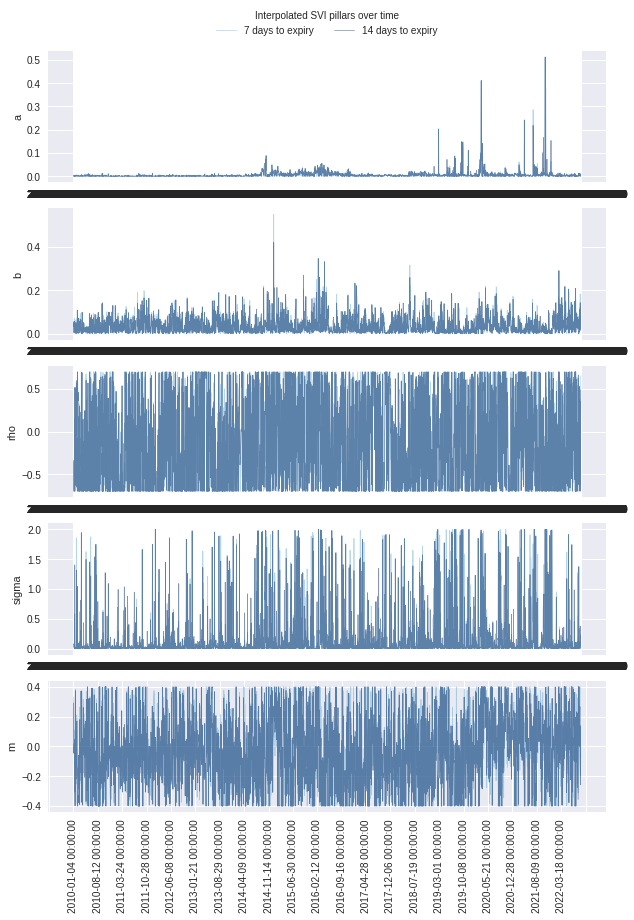

In [7]:
def plot_time_series( param_timeseries, save = 0 ):

    plt.close()
    
    # get the expiries and parameters
    param_names = param_timeseries.columns
    expiries = param_timeseries.index.get_level_values(1).unique()

    
    fig, axs = plt.subplots( len(param_names), 1, figsize = (10,14) )
    for param_idx, ax in enumerate( axs ):
        parameter = param_names[param_idx]
        for expiry_idx, expiry in enumerate( expiries ):
            color = plt.cm.Blues( (1+expiry_idx) / len(expiries), alpha = 0.5 ) # r is 0 to 1 inclusive
            series = param_timeseries.loc[ (slice(None),expiry), parameter ]
            dates = series.index.get_level_values(0)
            ax.plot(
                dates,
                series.values,
                label = "%i days to expiry" % expiry,
                c = color,
                lw = 0.75,
                ls = "-"
            )
        ax.set_ylabel( parameter )
        
    axs[0].legend(
        handles=axs[0].lines, 
        title='Interpolated SVI pillars over time', 
        bbox_to_anchor=(0.5, 1.375), 
        loc='upper center',
        fancybox = True,
        ncol=4
    )
    
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(151))

    return ax, fig

plot_time_series( param_timeseries, 1 )
plt.xticks(rotation=90)
plt.show()

# Create input pipeline for model

In [9]:
# Scaling
def fit_scalers( train_x, train_y, scaler_to_use ):
    input_scalers = []
    for i in range( train_x.shape[-2] ):
        scaler = scaler_to_use()
        scaler.fit( train_x[...,i,:].reshape(-1, train_x.shape[-3] ) )
        input_scalers.append( scaler )

    pred_scalers = []
    for i in range(train_y.shape[-1]):
        scaler = scaler_to_use()
        scaler.fit( train_y[...,i].reshape(-1, train_y.shape[-2] ) )
        pred_scalers.append( scaler )
        
    return input_scalers, pred_scalers

def scale_input( data, input_scalers ):
    scaled_params = []
    for i, scaler in enumerate( input_scalers ):
        scaled_param = scaler.transform( data[...,i,:].reshape( -1,len(expiries) ) )
        scaled_params.append(scaled_param)
    return np.stack( scaled_params, -1 ).reshape(data.shape)

def scale_target( data, pred_scalers, reverse = False ):
    scaled_params = []
    for i, scaler in enumerate( pred_scalers ):
        transformation = scaler.inverse_transform if reverse else scaler.transform
        scaled_param = transformation( data[...,i].reshape( -1,len(expiries) ) )
        scaled_params.append(scaled_param)
    return np.stack( scaled_params, -1 ).reshape(data.shape)

def get_data(train : "tuple", 
             predict : "tuple", 
             model_lags : int,
             scaler : "sklearn.preprocessing.scaler",
             dataset = param_timeseries, 
             report : "bool" = False, 
             diff_target : "bool" = False):
    
    '''
    The pipeline for pulling data from the timeseries
    Scaling is by default applied
    '''
    
    # make dataset to numpy array (dates,expiries,parameters)
    param_names = dataset.columns
    dates, expiries = dataset.index.levels
    data = np.stack( dataset.groupby( level = 0 ).apply( lambda dateview: dateview.values ) )

    # some functions to get dates and their indices
    get_dates = lambda slicer: dates[ dates.slice_indexer( *len(slicer)//2*slicer )  ]
    get_date_indices = lambda dates_subset: np.argwhere( [ date in dates_subset for date in dates ] ).flatten()

    # fetch the dates that we want to predict
    train_dates, test_dates = map( get_dates,(train, predict) )
    train_idxs, test_idxs = map( get_date_indices,(train_dates, test_dates) ) 

    # We need to remove dates where we dont have the sufficient lags to feed the model (i.e. first int(model_lags) dates)
    def adjust_for_lags( dates_idxs ):
        dates, idxs = dates_idxs # unpack
        drop_mask = model_lags<=idxs 
        return dates[ drop_mask ], idxs[ drop_mask ]
    (train_dates, train_idxs),(test_dates,test_idxs) = map( adjust_for_lags, ((train_dates, train_idxs),(test_dates,test_idxs)) )

    # make datasets
    inputs = lambda data, target_idxs: np.stack( [ data[ i - model_lags : i ] for i in target_idxs] )[...,None]
    train_x, test_x = [ inputs( data, idx ) for idx in (train_idxs,test_idxs) ]
    train_y, test_y = [ data[ idx ] - ( data[ idx - 1 ] if diff_target else 0 ) for idx in (train_idxs,test_idxs) ]
        
    # fit the scalers
    input_scalers, target_scalers = fit_scalers( train_x, train_y, scaler )
    
    # save the data
    data = {
        "dates" : {"train":train_dates,"test":test_dates},
        "paramnames" : dataset.columns.values,
        "train" : {"x" : train_x, 
                   "y" : train_y, 
                   "x_scaled" : scale_input(train_x,input_scalers), 
                   "y_scaled" : scale_target(train_y,target_scalers) },
        "test" : {"x" : test_x, 
                  "y" : test_y,
                  "x_scaled" : scale_input(test_x,input_scalers),
                  "y_scaled" : scale_target(test_y,target_scalers),},
        "scalers" : {"x" : input_scalers, "y" : target_scalers}
    }
        
    if report:
        print(
            "Training data goes from: %s to %s" % tuple( f(train_dates) for f in (min,max) ),
            "\n  Train input shape:  ", train_x.shape, 
            "\n  Train target shape: ", train_y.shape,
            "\nTest data goes from: %s to %s" % tuple( f(test_dates) for f in (min,max) ),
            "\n  Test input shape:  ", test_x.shape,
            "\n  Test target shape: ", test_y.shape, "\n"
        )
        
    return data

## Convolutional Long Short Term Memory Network

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def create_model(n_params, 
                 dropout, 
                 recurrent_dropout, 
                 n_convlstm_layers = 2,
                 hidden_activation =  tf.keras.activations.tanh, 
                 optimizer = keras.optimizers.Adam()):

    # input layer
    input_layer = layers.Input(shape= (None,len(expiries),len(params),1) )
    
    # lstm layers
    lstm = input_layer
    for i in range( n_convlstm_layers ):
        lstm =  layers.ConvLSTM2D( 
            kernel_size= (1,1), 
            filters=n_params, 
            data_format= 'channels_last', 
            return_sequences = i<n_convlstm_layers-1,
            activation=hidden_activation,
            padding = "same",
            dropout=dropout, 
            recurrent_dropout=recurrent_dropout
        )( lstm )
        lstm = layers.BatchNormalization()(lstm)    

    output = layers.Conv2D(
        filters=1, kernel_size=(1, 1), activation="linear", padding="same"
    )( lstm )
    output_layer = layers.Reshape( (len(expiries),len(params)) )(output)

    # compile
    model = Model( input_layer, output_layer )
    model.compile(
        loss= "MAE",
        optimizer=optimizer, 
    ) 
    
    print(model.summary())
    return model

def train_model(model, 
                dataset, 
                verbose = True, 
                save : "dir" = False,
                training_kwarg_overwrites : "dict" = {} ):
    
    # train until we run out of improvement
    callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=15),
    ]
    
    # train model
    training_kwargs = {
        "x" : dataset["train"]["x_scaled"],
        "y" : dataset["train"]["y_scaled"],
        "epochs" : 200,
        "batch_size" : 64,
        "verbose" : verbose,
        "validation_split" : 0.2,
        "callbacks" : callbacks,
    } 
    training_kwargs.update(training_kwarg_overwrites)
    train_hist = model.fit( **training_kwargs )
    
    if save:
        Path(save).mkdir(parents=True, exist_ok=True) # make a home for the models
        train_start, train_end = [ f( dataset["dates"]["train"] ) for f in (min,max) ]
        model_name = "-".join( date for date in [train_start, train_end] )
        model.save( save+model_name )
        
    return model, train_hist

## Check the error (MAE) of the model out of sample

## train a model

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# data & preprocessing params
train = (None,"2016-5-31 00:00:00")
test = ("2016-6-1 00:00:00",None)
lags = 10
diff_target = False
scaler = MinMaxScaler

# model params
neurons_per_layer = 64
dropout = 0.025
recurrent_dropout = 0.025
n_convlstm_layers = 1
hidden_activation = tf.keras.activations.tanh
optimizer = keras.optimizers.Nadam()

model = create_model( neurons_per_layer, dropout, recurrent_dropout, n_convlstm_layers, hidden_activation, optimizer )
dataset = get_data(train,test,lags,report=1, diff_target = diff_target, scaler = scaler)

model, train_hist = train_model(
    model, 
    dataset, 
    #training_kwarg_overwrites={"epochs" : 0}, 
    save = False 
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 5, 5, 1)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 5, 5, 64)          16896     
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 1)           65        
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 17,217
Trainable params: 17,089
Non-trainable params: 128
_______________________________________________________

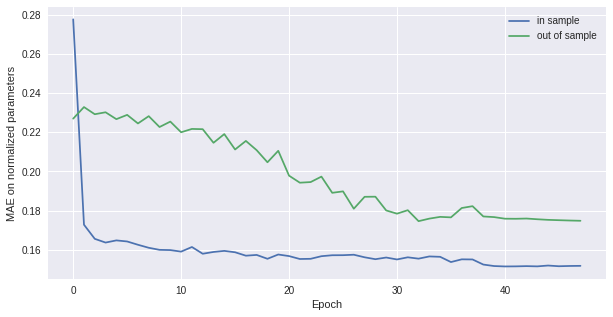

In [12]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot( train_hist.history["loss"], label = "in sample" )
ax.plot( train_hist.history["val_loss"], label = "out of sample" )
ax.set_xlabel("Epoch")
ax.set_ylabel("MAE on normalized parameters")
ax.legend()
plt.show()

### Compute MAE

In [12]:
# loss functions
MAE = lambda series: np.mean( abs(series) )
RMSE = lambda series: np.sqrt( np.mean( series**2 ) )

def SVI_smile(forward_log_moneyness,a,b,rho,sigma,m):

    displacement = forward_log_moneyness - m
    curvature = np.sqrt( displacement**2 + sigma**2 )
    smile = np.sqrt( ( a + b * ( rho * displacement + curvature ) ) )

    return smile / np.sqrt(t.values)

def get_model_preds(model,
                    dataset,
                    steps_ahead = 1,
                    which : "str" = "test",
                    diff_target : "bool" = False):
        
    #dates
    dates = dataset["dates"][which]
    
    # predict
    inputs = dataset[which]["x"]
    scalers = dataset["scalers"]["x"]
    
    for i in range(steps_ahead): 
        
        scaled_inputs = scale_input(inputs,scalers)
        uscaled_pred = model.predict( scaled_inputs )

        # scale
        y_scaler = dataset["scalers"]["y"]
        scaled_target = scale_target( uscaled_pred, y_scaler, True )

        # correct if we predict differences
        if diff_target:
            scaled_target =+ dataset[which]["x"][:,-1,...,0]

        # adjust for no-arb bounds
        bounds = lambda preds: np.minimum( [1,1,1,1,1], np.maximum( [0,0,-1,0,-1], preds ) )
        scaled_target = bounds( scaled_target )
        
        inputs = np.concatenate( 
            (
                inputs[:,1:], # without the last observation
                scaled_target.reshape( (inputs.shape[0],1,*inputs.shape[2:]) ) # reshaped to input shape
            ),
            axis=1
        )
            
    # shape to df
    index = pd.MultiIndex.from_product( (dates, expiries) )
    columns = dataset["paramnames"]
    preds = pd.DataFrame( scaled_target.reshape( -1,5 ), index, columns )
    
    return preds

def evaluate_loss(predictions, 
                  param_timeseries = param_timeseries, 
                  loss = MAE ):
    
    # the dates for which we have predicted
    series_dates = predictions.index.unique(level=0)
    dates_of_prediction = series_dates[:-t_ahead] # we dont know the m last predictions' realizations
    dates_of_realization = series_dates[t_ahead:] # shift the dates forward
    
    pred_smiles = SVI_series_to_smiles( predictions )
    realized_smiles = SVI_series_to_smiles( param_timeseries )    
    
    errors = pred_smiles.loc[dates_of_prediction] - realized_smiles.loc[dates_of_realization].values
    return errors.groupby( axis=0, level=1 ).apply( loss ).mean(1)

def SVI_smile(forward_log_moneyness,a,b,rho,sigma,m):

    displacement = forward_log_moneyness - m
    curvature = np.sqrt( displacement**2 + sigma**2 )
    smile = np.sqrt( ( a + b * ( rho * displacement + curvature ) ) )

    return smile / np.sqrt(t.values)

def SVI_series_to_smiles(param_timeseries,
                         strikerange = (-.2,.2),
                         n_strikes = 401):
    
    forward_log_moneyness = np.linspace( *strikerange,n_strikes )[...,None]
    sqrt_t = np.sqrt( param_timeseries.index.get_level_values(1).values / 255 )[None,]
    a,b,rho,sigma,m = param_timeseries.values.T  
    
    displacement = forward_log_moneyness - m
    curvature = np.sqrt( displacement**2 + sigma**2 )
    scaled_vol_smile = np.sqrt( ( a + b * ( rho * displacement + curvature ) ) )    
    
    bs_smile = scaled_vol_smile/sqrt_t
    
    return pd.DataFrame( bs_smile.T, index = param_timeseries.index, columns = forward_log_moneyness.squeeze() )

In [13]:
save = 0
lossname = "MAE"
loss = MAE if lossname == "MAE" else RMSE

t_aheads = [1,3,5,10,20,30]

losses = pd.DataFrame()
real_losses = pd.DataFrame()

for t_ahead in t_aheads:

    OOS_preds = get_model_preds( model, dataset, t_ahead, "test", diff_target )
    oos_dates = OOS_preds.index.levels[0]
    OOS_naive_loss = evaluate_loss(param_timeseries.loc[oos_dates],loss=MAE)
    OOS_pred_loss = evaluate_loss(OOS_preds,loss=loss)
    relative_loss = OOS_pred_loss - OOS_naive_loss
    relative_loss.name = "t+{} {}".format(t_ahead,lossname)
    losses = pd.concat( [losses, relative_loss], axis = 1 )
    real_losses = pd.concat( [real_losses, OOS_pred_loss], axis = 1  )

if save: losses.to_excel("./plots/volatility_errors.xlsx")
losses

45/45 [==============================] - 1s 13ms/step


,t+1 MAE,t+3 MAE,t+5 MAE,t+10 MAE,t+20 MAE,t+30 MAE
7,-0.0012,-0.0029,-0.0067,-0.0001,0.0983,0.1796
14,-0.0106,-0.0085,-0.0055,0.0140,0.0779,0.1553
21,-0.0088,-0.0060,-0.0011,0.0208,0.0801,0.1498
30,-0.0043,-0.0015,0.0030,0.0338,0.0972,0.1663
60,0.0099,0.0164,0.0208,0.0523,0.1136,0.1703


In [14]:
real_losses

,0,0,0,0,0,0
7,0.2310,0.2497,0.2649,0.3030,0.4000,0.5050
14,0.1599,0.1718,0.1819,0.2171,0.2978,0.3818
21,0.1272,0.1368,0.1460,0.1807,0.2570,0.3342
30,0.1024,0.1121,0.1206,0.1579,0.2360,0.3135
60,0.0705,0.0815,0.0912,0.1279,0.2014,0.2662


In [15]:
save = 0
lossname = "RMSE"
loss = MAE if lossname == "MAE" else RMSE

t_aheads = [1,3,5,10,20,30]

losses = pd.DataFrame()
real_losses = pd.DataFrame()

for t_ahead in t_aheads:

    OOS_preds = get_model_preds( model, dataset, t_ahead, "test", diff_target )
    oos_dates = OOS_preds.index.levels[0]
    OOS_naive_loss = evaluate_loss(param_timeseries.loc[oos_dates],loss=MAE)
    OOS_pred_loss = evaluate_loss(OOS_preds,loss=loss)
    relative_loss = OOS_pred_loss - OOS_naive_loss
    relative_loss.name = "t+{} {}".format(t_ahead,lossname)
    losses = pd.concat( [losses, relative_loss], axis = 1 )
    real_losses = pd.concat( [real_losses, OOS_pred_loss], axis = 1  )
if save: losses.to_excel("./plots/volatility_errors.xlsx")
losses

45/45 [==============================] - 1s 13ms/step


,t+1 RMSE,t+3 RMSE,t+5 RMSE,t+10 RMSE,t+20 RMSE,t+30 RMSE
7,0.1452,0.1472,0.1448,0.1568,0.2449,0.3151
14,0.0951,0.0992,0.1027,0.1247,0.1822,0.2475
21,0.0798,0.0823,0.0865,0.1105,0.1604,0.2215
30,0.0721,0.0716,0.0755,0.1069,0.1602,0.2210
60,0.0422,0.0498,0.0553,0.0857,0.1450,0.1981


In [18]:
real_losses

,0,0,0,0,0,0
7,0.6476,0.6515,0.6442,0.5986,0.5390,0.5002
14,0.4476,0.4483,0.4431,0.4145,0.4101,0.4096
21,0.3548,0.3591,0.3576,0.3484,0.3626,0.3870
30,0.3002,0.3096,0.3121,0.3044,0.3098,0.3305
60,0.1289,0.1316,0.1339,0.1385,0.1601,0.1844


45/45 [==============================] - 1s 14ms/step


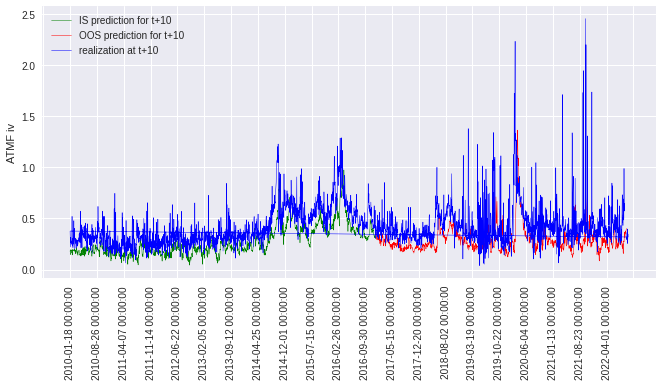

In [16]:
strike = 0 
expiry = 21
t_ahead = 10

IS_preds, OOS_preds = [ get_model_preds( model, dataset, t_ahead, s, diff_target ) for s in ["train","test"] ]
IS_pred_smiles,OOS_pred_smiles,realized_smiles = [ SVI_series_to_smiles(preds) for preds in [IS_preds, OOS_preds,param_timeseries] ]

slicer = ((slice(None),expiry),strike)

plt.close()
fig, ax = plt.subplots( figsize=(11,5) )

ax.plot( IS_pred_smiles.index.unique(level=0), IS_pred_smiles.loc[slicer], color = "green", lw = 0.5, label = "IS prediction for t+{}".format(t_ahead) ) 
ax.plot( OOS_pred_smiles.index.unique(level=0), OOS_pred_smiles.loc[slicer], color = "red", lw = 0.5, label = "OOS prediction for t+{}".format(t_ahead) )
ax.plot( realized_smiles.index.unique(level=0)[:-t_ahead], realized_smiles.loc[slicer].iloc[t_ahead:], color = "blue", lw = 0.5, label = "realization at t+{}".format(t_ahead) )

ax.set_ylabel("ATMF" + ( "+{:.0f}bp".format(strike*10000) if strike!=0 else"") +" iv" )
ax.xaxis.set_major_locator(ticker.MultipleLocator(151))
ax.legend()
plt.xticks(rotation=90)

plt.savefig("predictionplot.png")

# Single date plot fit

In [17]:
date = param_timeseries.index.levels[0].unique()[2000] #1200

expiry = 14
t_ahead = 5

date_ahead = param_timeseries.index.levels[0].unique()[2000 + t_ahead]

a = param_timeseries.loc[(date_ahead, expiry), 'a']
b = param_timeseries.loc[(date_ahead, expiry), 'b']
rho = param_timeseries.loc[(date_ahead, expiry), 'rho']
sigma = param_timeseries.loc[(date_ahead, expiry), 'sigma']
m = param_timeseries.loc[(date_ahead, expiry), 'm']

min_fwd , max_fwd = [-0.2*1.05, 0.2*1.05]

def objective(x, a, b, rho, sigma, m, tenor):
	return np.sqrt((a + b*(rho*(x-m)+ np.sqrt((x-m)**2 + sigma**2)))/(tenor/252))
 
x_line = np.linspace(-0.2, 0.2, 401)*1.05
y_line = objective(x_line, a, b, rho, sigma, m, expiry)

45/45 [==============================] - 1s 28ms/step


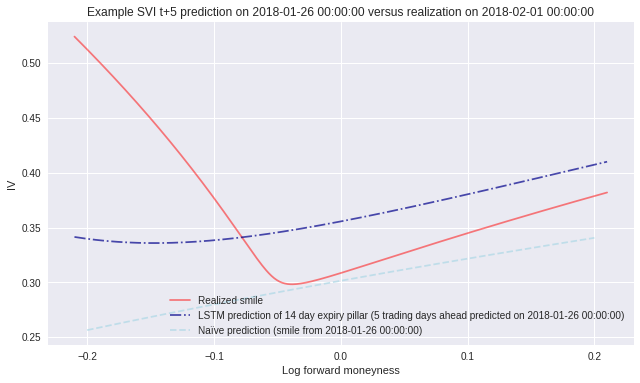

In [18]:
date = param_timeseries.index.levels[0].unique()[2000] #1200



# Connect to db
# fit_conn = sqlite3.connect(save_fit_db_path)

# create plot
scaling = .05
width = 1
height = .4
fig, ax = plt.subplots(figsize = (210*scaling*width,297*scaling*height) ) # A4

# some stuff
datestr = date


min_fwd , max_fwd = [-0.2, 0.2]

ax.plot( x_line, y_line, c = "r", alpha=0.5,
                 label = "Realized smile")
# interpolated smile from model
extend_smile = 1.05
all_preds = pd.concat( [get_model_preds( model, dataset, t_ahead, sample, diff_target ) for sample in ("train","test")] )
pred_date = all_preds[:date].index.get_level_values(0).unique()[-t_ahead]
predicted_params = all_preds.loc[ [(pred_date,expiry)], ]
interpolated_smile = SVI_series_to_smiles(predicted_params, (min_fwd*extend_smile, max_fwd*extend_smile))
ax.plot( interpolated_smile.columns, interpolated_smile.values.squeeze(), 
        c = "darkblue", alpha = 0.7,
        ls = "-.", label = "LSTM prediction of {} day expiry pillar ({} trading days ahead predicted on {})".format(expiry,t_ahead,(pred_date) )
       )

# Naive pred
extend_smile = 1.05
naive_smile = realized_smiles.loc[ [(pred_date,expiry)], extend_smile*min_fwd : extend_smile*max_fwd ]
ax.plot( naive_smile.columns, naive_smile.values.squeeze(), 
        c = "lightblue", alpha = 0.7,
        ls = "--", label = "Naïve prediction (smile from {})".format((pred_date) )
       )


ax.set_title("Example SVI t+{} prediction on {} versus realization on {}".format(t_ahead,(pred_date),datestr))
ax.set_xlabel("Log forward moneyness")
ax.set_ylabel("IV")
ax.legend(loc="lower right")